In [1]:
import cv2
import matplotlib.patches as patches
import numpy as np
import plotly.express as px
from matplotlib import pyplot as plt

from anpr.binarization.adaptative_gaussian import AdaptativeGaussianBinarizer
from anpr.binarization.adaptative_mean import AdaptativeMeanBinarizer
from anpr.binarization.kittler import KittlerBinarizer
from anpr.binarization.otsu import OtsuBinarizer
from anpr.core.binarizer import Binarizer
from anpr.core.image_processor import ImageProcessor
from anpr.datasets.open_alpr import OpenALPRDataset, OpenALPRImage
from anpr.detection.estimator_detector import EstimatorDetector
from anpr.generic.brightness import Brightness
from anpr.generic.contrast import Contrast
from anpr.generic.filter_bilateral import FilterBilateral
from anpr.generic.filter_gaussian import FilterGaussian
from anpr.generic.filter_mean import FilterMean
from anpr.generic.filter_median import FilterMedian
from anpr.generic.filter_nlm import FilterNLM
from anpr.generic.grayscale import GrayScale
from anpr.generic.histogram_normalization import HistogramNormalization
from anpr.generic.morphological_closing import MorphologicalClosing
from anpr.generic.morphological_opening import MorphologicalOpening
from anpr.generic.negative import Negative
from anpr.ocr.easy_ocr import EasyOCR

In [2]:
class AggregateProcessor(ImageProcessor):
    def __init__(self, processors: list[ImageProcessor]) -> None:
        self._processors = processors

    def process(self, image: np.ndarray) -> np.ndarray:
        for p in self._processors:
            image = p.process(image)

        return image

In [3]:
ds = OpenALPRDataset()
indices = [0, 30, 50, 80, 100, 120, 180, 200, 220, 240, 300, 320, 380, 400, 420]

In [4]:
start = [FilterNLM(21),
         FilterBilateral(11, 5, 5),
         GrayScale(),
         Brightness(-30),
         HistogramNormalization(),
         Contrast(0.5)]

segmentation = [OtsuBinarizer(),
                AdaptativeMeanBinarizer(11, 5),
                Negative()]

processor = AggregateProcessor(start + segmentation)

In [5]:
detector = EstimatorDetector(seed=42,
                             preprocessing=processor,
                             pp_in_predict=True)
detector.fit(indices, ds)

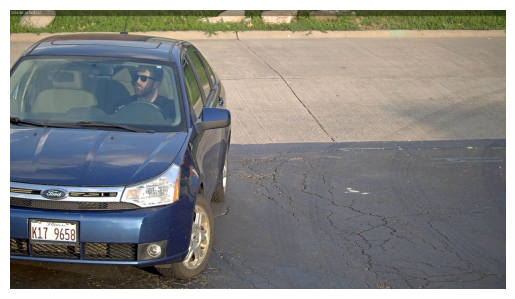

In [6]:
img = ds.image_at(5).image
plt.axis("off")
plt.imshow(img)

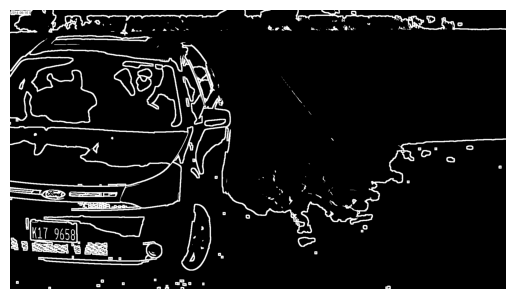

In [7]:
plt.axis("off")
plt.imshow(processor.process(img), cmap='gray')

In [8]:
result = detector.detect(img)

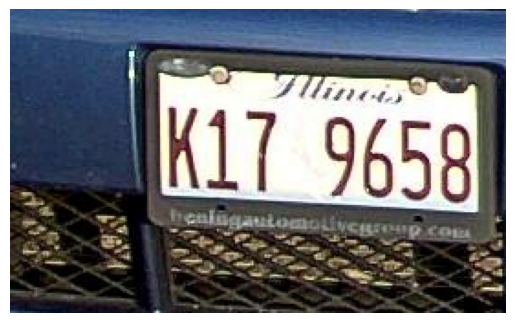

In [9]:
if result.found_plate:
    plt.axis("off")
    plt.imshow(result.plate_image)

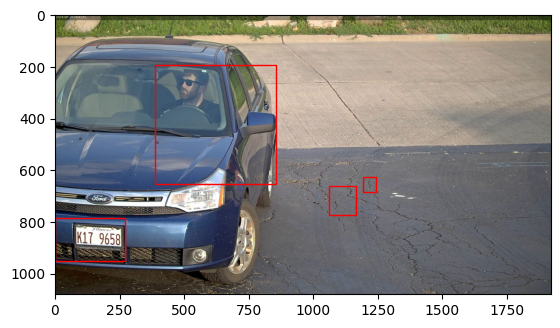

In [10]:
fig, ax = plt.subplots()
ax.imshow(img)

if result.n_candidates > 0:
    for c in result.extras.candidates:
        x, y, w, h = c
        ax.add_patch(patches.Rectangle((x, y), w, h, 
                                    linewidth=1, 
                                    edgecolor='r', 
                                    facecolor='none'))


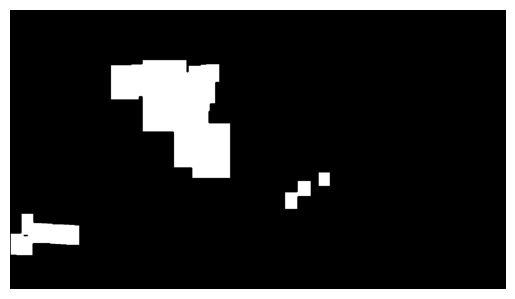

In [12]:
plt.axis('off')
plt.imshow(result.extras.final_blob, cmap='gray')